**필요한 라이브러리 import 하기**  
전체 코드를 실행시키는 데에 필요한 모든 라이브러리를 한 번에 가져오기

In [218]:

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

import xgboost as xgb
import lightgbm as lgb

from scipy.stats import norm # Analysis 
from sklearn.preprocessing import StandardScaler # Analysis 
from scipy import stats # Analysis 

import matplotlib.pyplot as plt  # visulization
%matplotlib inline
import seaborn as sns   # visulization

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

print("import 확인")

import 확인


###  데이터 준비하기

In [474]:
data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION_/E9_kaggle_competition/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print("데이터 준비하기")

데이터 준비하기


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [475]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- grade : 집의 등급을 매긴 변수로 등급이 높을 수록 가격이 높다는 의미입니다.

- yr_renovated의 경우 0인 경우재건축을 하지 않았다는 의미입니다.

- sqft_living 과 sqft_living15처럼 비슷한 값이 보입니다. 둘은 15년도를 기준으로 크기 계산의 기준에 따라 다른 값을 보입니다. 두 값의 차이가 있기에 해당 부분을 전처리 해서 진행하면될 것 같습니다.

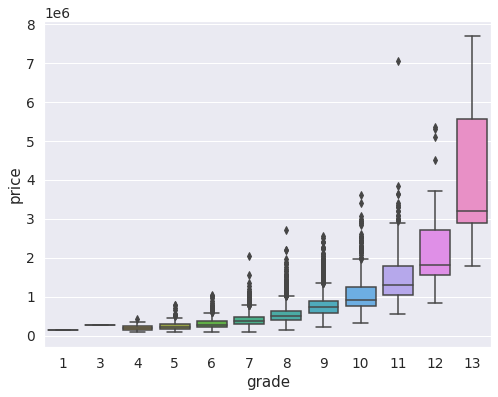

In [476]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

grade값이 클 수록 가격이 더 높아지고 있습니다.
- 그렇지만 데이터의 이상치들을 관측하기 위헤 price 값을 정규화한 후 다시 진행하겠습니다. 

In [477]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

min max의 차이가 크게 나오고 std가 굉장히 큰 편입니다.  
plt 시각화로 다시 확인해 보겠습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

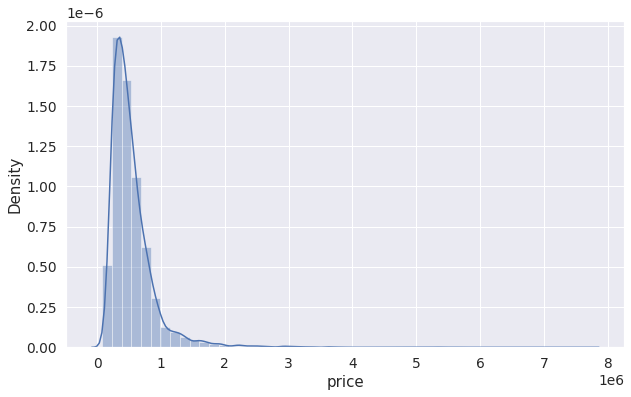

In [478]:
f, ax = plt.subplots(figsize=(10, 6))
sns.distplot(train['price'])

**price** 분포가 왼쪽으로 치우쳐 있는것을 확인할 수 있습니다.  

**np.log1p()** 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 **np.exp1m()**을 활용해서 되돌리겠습니다.

**np.exp1m()**은 **np.log1p()**과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해 줍니다.

In [479]:
print("비대칭도(왜도)(Skewness): %f" % train['price'].skew())
print("첨도(Kurtosis): %f" % train['price'].kurt())

비대칭도(왜도)(Skewness): 4.290252
첨도(Kurtosis): 40.154919


- 비대칭도(왜도) : <br>
 **왜도가 음수**일 경우에는 확률밀도함수의 왼쪽 부분에 긴 꼬리를 가지며 중앙값을 포함한 자료가 오른쪽에 더 많이 분포해 있다.  <br>
 **왜도가 양수**일 때는 확률밀도함수의 오른쪽 부분에 긴 꼬리를 가지며 자료가 왼쪽에 더 많이 분포해 있다는 것을 나타낸다. 
  - 평균과 중앙값이 같으면 왜도는 0이 된다.


- 첨도 (kurtosis / kurtosis) : 첨도 값 (K)이 3에 가까울 경우, scatter은 정규 분포에 가깝습니다. (K <3), 분포가 정규 분포보다 더 평탄하게 평탄하다고 판단 할 수 있으며, 첨도가 3보다 큰 양수인 경우 (K> 3), 분포가보다 뾰족한 분포로 생각 할 수 있습니다.

---

첨도, 왜도가  정규분포를 따르지 않고 분산또한 큰 것을 확인 할 수 있습니다.  
Normalize를 통해 price의 분포가 정규분포를 가지도록 만들어 주겠습니다.

- Normalize를 **no.log1p()**로 로그 변환 시켜서 진행하겠습니다.

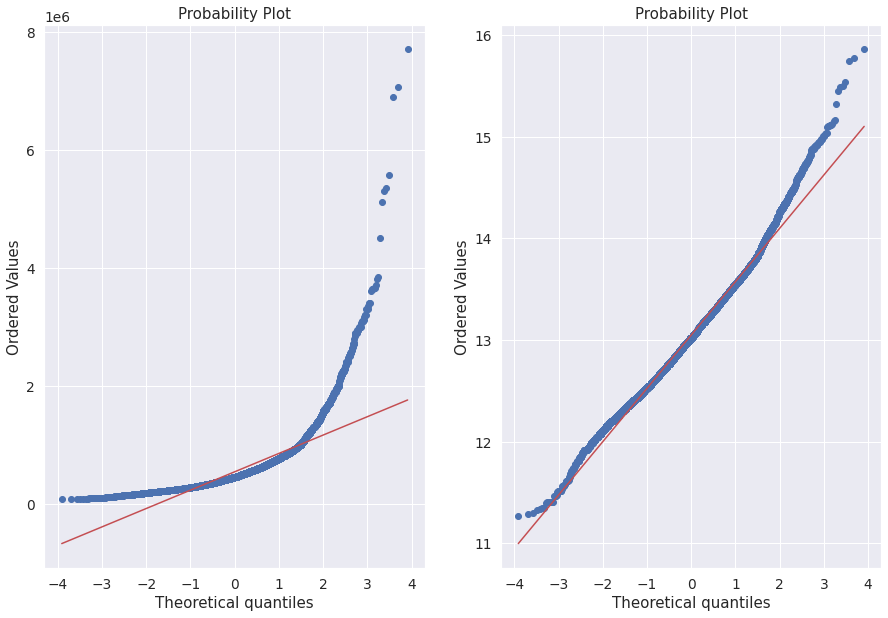

In [480]:
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1,2,1)
res = stats.probplot(train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(train['price']), plot=plt)

기존보다 더 정규성을 가진것을 확인할 수 있습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

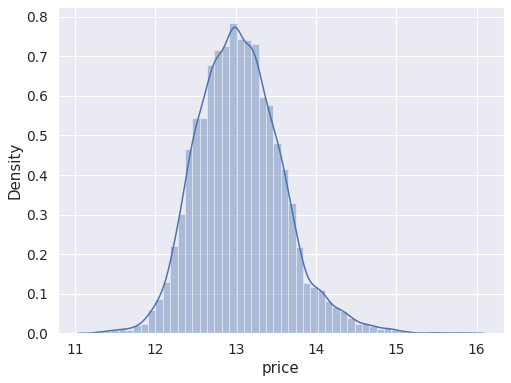

In [481]:
# histogram 분포
train['price'] = np.log1p(train['price'])

f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

위에서 짆행했었던 grade를 다시 살펴보겠습니다.

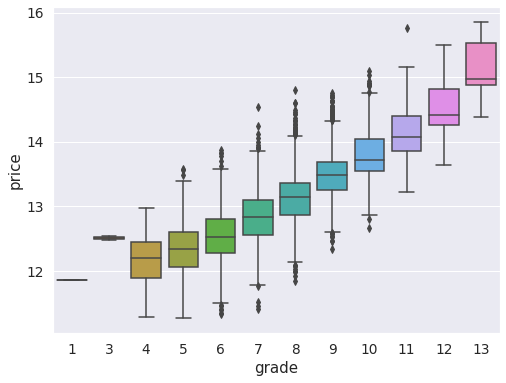

In [482]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

위에서 진행했던 grade보다 **이상치**들이 더 잘관측되고 있습니다.
- grade 3의 경우 값이 앞의 값보다 크게 증가했습니다.
- grade 7, 8에서 이상치들이 관측되고 있습니다.
- grade 8, grade 11에서 차이가 큰 이상치가 나타납니다.

이 부분을 신경 쓰고 데이터 전처리를 진행헤야 할 거 같습니다.

#### 변수시각화 ( 반응변수 )
- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용

목적변수인 가격과 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵입니다.  
price와의 상관도가 높은 순으로 21개의 각 컬럼에 대한 값을 보도록 하겠습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode']


<AxesSubplot:>

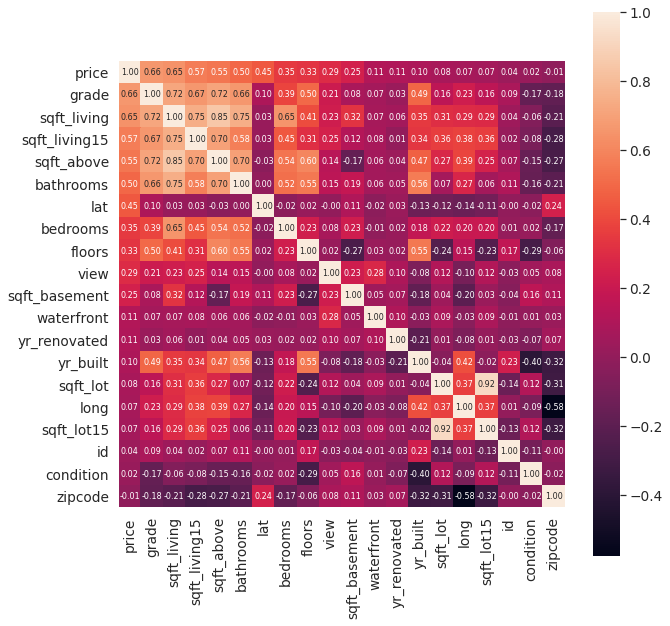

In [483]:
# correlation이 높은 순의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 21 x 21
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

위의 히트맵을 보면 알수 있는 부분은 목적 변수와 상관도가 높은 변수는 집의 등급, 주거공간의 크기, 전체크기, 화장실과 위도 값 등이 있네요.

- 위도(lat) 같은 경우 데이터가 미국 집을 기준으로 하기에 북쪽으로 갈 수록 살기 좋은 집들이 많이 있다고 합니다.

- condition, zipcode 같은 경우 집의 상태는 금액에 크게 좌우 하지 않는것을 나타내고 있습니다.

#### sqlf_living(주거 평방 피트) sqlf_lot(부지 평방 피트) 
sqlf_living은 실제 사용 면적 / sqlf_lot는 총 부지의 면적으로 생각하면 됩니다.

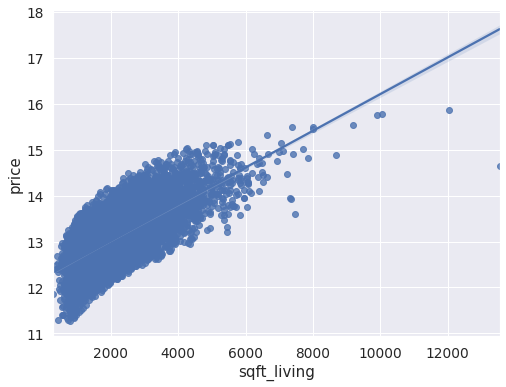

In [484]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

14-15 사이에 12000을 넘어선 이상치로 생각되는 점이 보입니다.

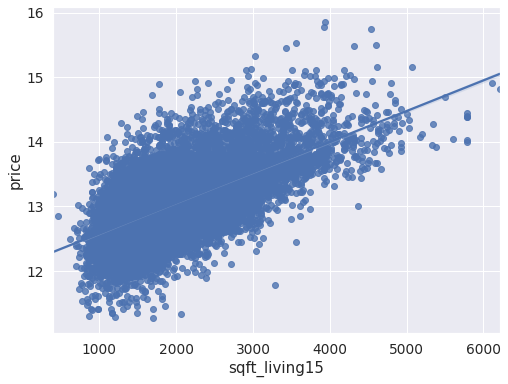

In [485]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

sqft_living15의 경우 15년도를 기준으로 했기에 sqft_livin에 비해 가격의 분산이 큰것을 확인할 수 있습니다.

- 재건축을 해서 생긴 영향으로 보입니다.

- sqft_living과 sqft_living15d의 차이가 있다보니 적절한 (Feature Engineering)를 진행해야할 것 같습니다. 

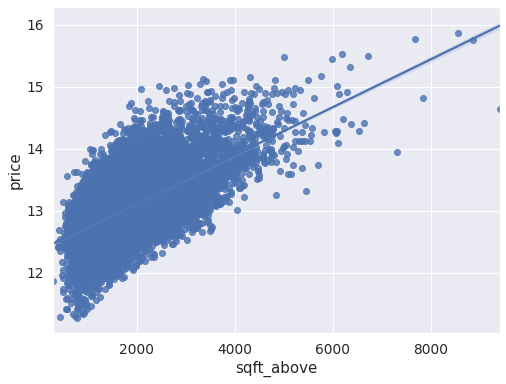

In [486]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

- sqft_above의 값이 7000이상이지만 price 값이 14에 걸친 값을 확인해 보겠습니다.

#### 결측치 확인
데이터에 결측치가 있는지를 확인하겠습니다  
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

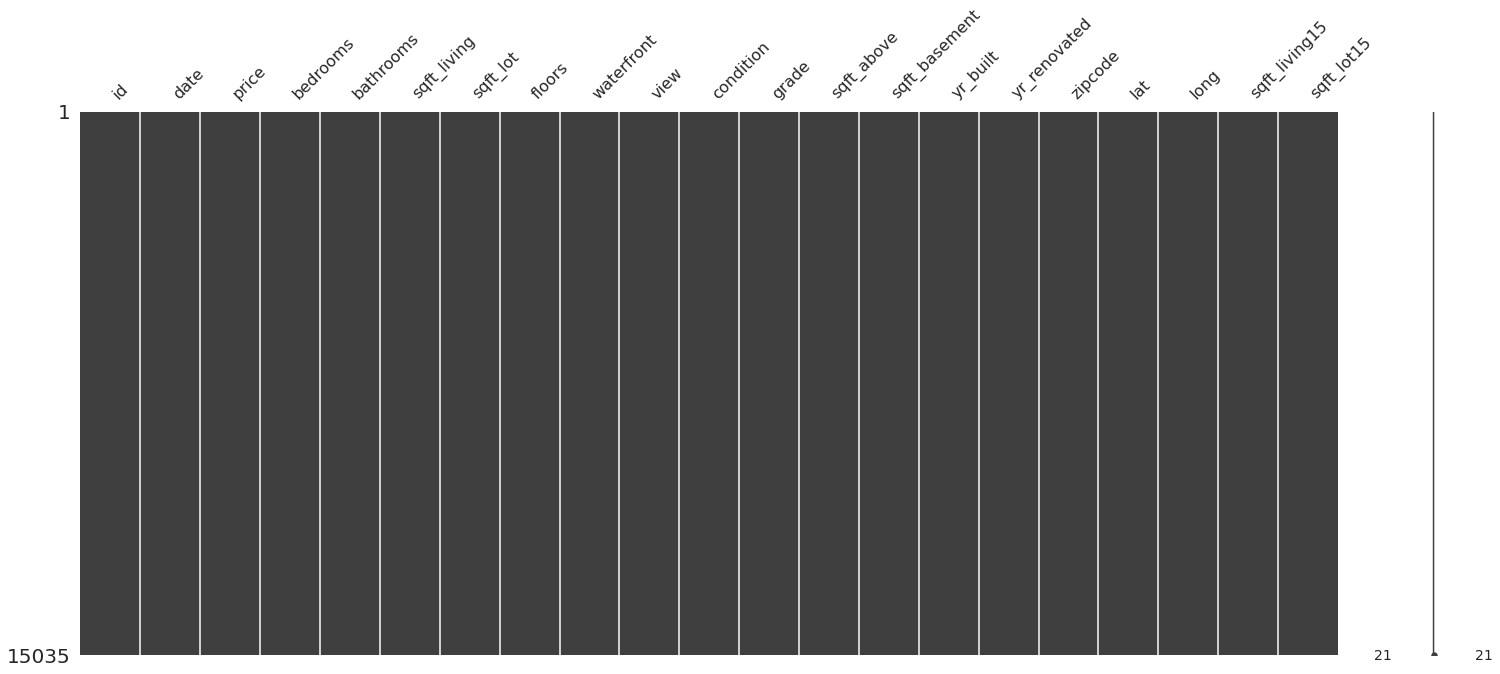

In [487]:
msno.matrix(train)

결측치가 있는 부분이 있다면 하얗게 나오지만 결측치가 없는 경우 매트릭스 전체가 까맣게 나옵니다.

그래도 다시한번 모든 변수에 걸쳐 결측치가 있는지 확인하겠습니다.

In [488]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


확인해보니 결측치가 보이지 않네요.

---

- 우선은 위의 정보를 가지고 데이터 전처리를 진행하겠습니다.

### 2. 데이터 전처리

#### 이상치 제거
sqft_living, grade에서 발견한 이상치 들을 제거하겠습니다.

#### sqtf_living 이상치 처리

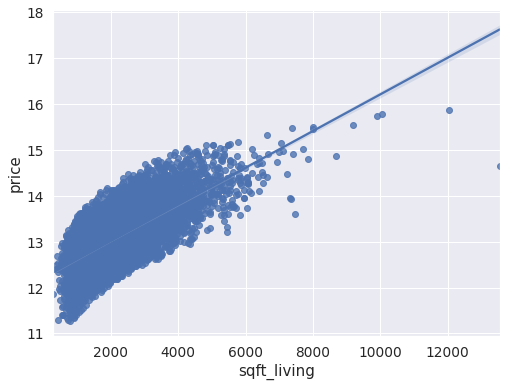

In [489]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
fi, ax =  plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [490]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


다른값들에 비해 sqft_living만 비정상적으로 꽤 큰 것을 알 수 있습니다.  
price와 상관성이 높은 grade와 다른 평수들을 살펴봐도 큰 의미는 없어보이므로 제거하도록 하겠습니다.

In [491]:
train = train.loc[train['id']!=8912]

#### sqft_above 이상치 처리

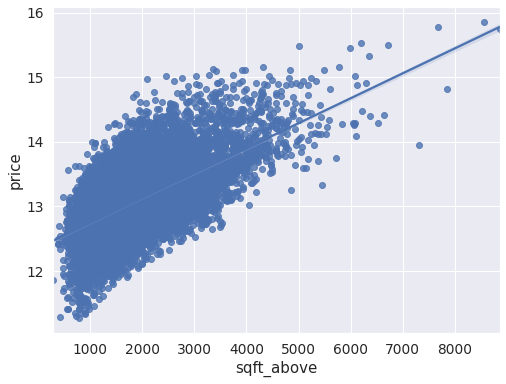

In [492]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
fi, ax =  plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

In [493]:
train.loc[(train['sqft_above'] > 7000) & (train['price'] < 14)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12921,12921,20140708T000000,13.942364,5,4.0,7320,217800,2.0,0,0,...,11,7320,0,1992,0,98058,47.4473,-122.086,3270,34500


sqtft_lot와 sqft_living를 봤을때 15를 기준으로 나웠을때 큰 차이가 있기에 결측치로 판단해 제거하겠습니다.

In [494]:
train = train.loc[train['id']!=12921]

#### grade 이상치 처리

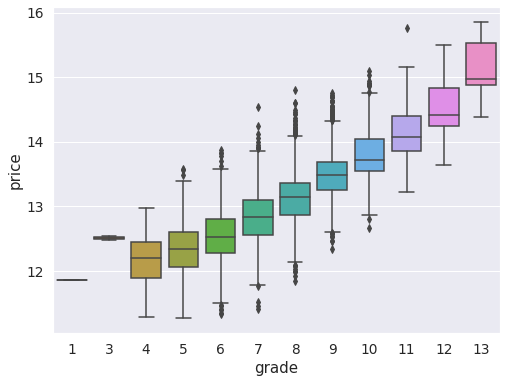

In [495]:
data = pd.concat([train['price'], train['grade']], axis=1)
fi, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [496]:
# 3등급인데 price가 높은 경우의 처리를 진행하겠습니다.
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


grade와 sqft_living 모두 낮은 값임에도 price가 높에 측정되어 있습니다.   
따라서, 위의 두 값 모두 이상치로 간주하고 제거하겠습니다.

In [497]:
# 7등급이고 price가 14 초과인 경우
train.loc[(train['grade']==7) & (train['price']>14)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
647,647,20140604T000000,14.054528,5,2.50,3200,17204,1.0,0,0,...,7,2160,1040,1952,0,98004,47.6209,-122.222,4090,15732
8148,8148,20150430T000000,14.250535,4,2.25,2640,3000,2.0,0,0,...,7,2080,560,1908,0,98109,47.6313,-122.344,1910,3000
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389
12457,12457,20140801T000000,14.115616,3,2.00,2070,9600,1.0,0,1,...,7,1590,480,1946,0,98039,47.6160,-122.239,3000,16215


In [498]:
# 7등급이고 prcie가 14.5 초과인 경우
train.loc[(train['price']>14.5) & (train['grade'] == 7)] 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


sqtf_living 기준이 15를 기준해서 오히려 작아졌고 다른 데이터와 비교 했을때  
가격이 지나치게 매겨진것 같아서 결측치로 판단하고 제거하겠습니다.

In [499]:
train.loc[(train['price']>14) & (train['grade'] == 8)].head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
306,306,20150225T000000,14.077876,3,2.00,2350,15021,1.0,0,0,...,8,1770,580,1976,0,98004,47.6408,-122.219,3530,15715
359,359,20150210T000000,14.062371,5,2.50,3400,9500,2.0,0,1,...,8,3400,0,1977,0,98027,47.5645,-122.082,3080,11081
983,983,20150511T000000,14.603968,5,4.25,4640,22703,2.0,1,4,...,8,2860,1780,1952,0,98052,47.6393,-122.097,3140,14200
1142,1142,20141022T000000,14.133965,3,1.50,1850,10572,1.0,0,0,...,8,1850,0,1953,0,98004,47.6194,-122.208,3030,12752
1542,1542,20141027T000000,14.346139,5,2.00,2500,15250,2.0,1,4,...,8,2500,0,1942,0,98008,47.5883,-122.111,1880,18782
2037,2037,20141031T000000,14.151984,4,4.50,3080,10550,2.0,0,3,...,8,1940,1140,1976,2007,98040,47.5806,-122.244,2780,10550
2454,2454,20141020T000000,14.062840,4,2.50,3560,15450,1.0,0,1,...,8,2060,1500,1977,0,98040,47.5657,-122.230,3680,17314
2644,2644,20150415T000000,14.030623,4,3.00,3010,6139,2.0,0,4,...,8,2560,450,1950,1972,98115,47.6799,-122.268,2100,6798
2853,2853,20140911T000000,14.141211,3,3.00,2490,3600,2.0,0,3,...,8,1790,700,1911,0,98119,47.6313,-122.369,2490,3600
2862,2862,20150317T000000,14.115616,4,2.00,2240,10296,1.0,0,0,...,8,2240,0,1948,0,98004,47.6177,-122.217,2500,10918


In [500]:
# 8듭급이지만 높은 price를 가진 값들
train.loc[(train['price']>14.5) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
983,983,20150511T000000,14.603968,5,4.25,4640,22703,2.0,1,4,...,8,2860,1780,1952,0,98052,47.6393,-122.097,3140,14200
7173,7173,20140813T000000,14.808763,5,4.00,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295
10037,10037,20140825T000000,14.603968,3,2.00,3570,30456,1.0,0,1,...,8,2070,1500,1946,1982,98039,47.6413,-122.240,3570,27418


위의 7173 id를 가진 값을 보면 sqft_living가 sqft15가 되면서 크게 줄었지만 가격은 가장 큰 것을 확인할 수 있습니다.
- 결측치라 판단하고 제거하겠습니다.

In [501]:
# price가 15 이상의 11등급 건물
train.loc[(train['price']>15) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1499,1499,20141114T000000,15.163584,4,4.25,5770,21300,2.0,1,4,...,11,5770,0,1980,0,98040,47.5850,-122.222,4620,22748
2775,2775,20140611T000000,15.770310,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
4598,4598,20150421T000000,15.110238,6,4.75,5480,19401,1.5,1,4,...,11,3910,1570,1936,0,98105,47.6515,-122.277,3510,15810
7297,7297,20150508T000000,15.039286,4,4.00,4260,11765,2.0,0,0,...,11,3280,980,1939,2010,98112,47.6380,-122.288,4260,10408
9814,9814,20140904T000000,15.009433,5,4.75,6200,13873,2.0,1,4,...,11,4440,1760,1989,0,98008,47.6050,-122.112,2940,13525
10645,10645,20140911T000000,15.107742,4,3.25,4830,22257,2.0,1,4,...,11,4830,0,1990,0,98039,47.6409,-122.241,3820,25582
12646,12646,20141230T000000,15.009433,3,3.25,4220,41300,1.0,1,4,...,11,2460,1760,1958,1987,98008,47.6083,-122.110,3810,30401
14231,14231,20150402T000000,15.022978,5,3.75,5350,15360,1.0,0,1,...,11,3040,2310,2008,0,98004,47.6480,-122.218,3740,15940


In [502]:
## 11등 급에서 큰 값을 보이는 값
train.loc[(train['price']>15.2) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


- sqft_living과 sqft_living15의 차이가 큰 것을 확인할 수 있습니다.  

같은 등급의 다른 건물을 봤을때 sqft_living과 sqft_living15의 차이가 크지 않지만,  해당 데이터의 경우 큰 차이를 나타내기ㅣ에 결측치로 판단해서 제거하겠습니다. 

In [503]:
# 위에서 찾은 결측치 id를 기준으로 제거하겠습니다.
# id : 2775, 7173, 12346, 2302, 4123
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=2775]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=12346]

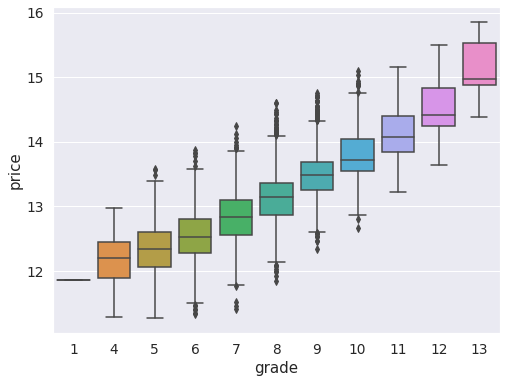

In [504]:
data = pd.concat([train['price'], train['grade']], axis=1)
fi, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

결측치를 제거하고난 후 전 보다 깔끔해졌습니다.

#### 데이터 정규화

In [251]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for sc in skew_columns:
    train[sc] = np.log1p(train[sc].values)
    test[sc] = np.log1p(test[sc].values)

#### 데이터 값 수정

date 년, 월 부분으로 전처리 진행

In [505]:
for df in [train,test]:
    df['date'] = df['date'].apply(lambda x : x[0:6]).astype(int)
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built']) # Nan인 경우 yr_built값 사용

In [506]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639
1,15036,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1965.0,98136,47.5208,-122.393,1360,5000
2,15037,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,2001.0,98053,47.6561,-122.005,4760,101930
3,15038,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,1960.0,98146,47.5123,-122.337,1780,8113
4,15039,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,2003.0,98038,47.3684,-122.031,2390,7570


In [507]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,12.309987,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,201502,12.100718,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,201502,13.142168,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,201406,12.458779,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,201501,12.583999,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [508]:
# 데이터 변수 수정
for df in [train, test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

date 전처리 한 후  **타겟 데이터**에 해당하는 price 컬럼 부분을 삭제하겠습니다.  
**y** 변수에 **price**를 넣어두고, **train**에서는 삭제하겠습니다.

In [509]:
y = train['price']

del train['price']
print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated'],
      dtype='object')


**id** 컬럼도 삭제하겠습니다.

In [510]:
del train['id']
del test['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated'],
      dtype='object')


In [511]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,...,47.5112,-122.257,1340,5650,4.00,0.208850,1180,1.0,0.237168,0
1,201502,2,1.00,770,10000,1.0,0,0,3,6,...,47.7379,-122.233,2720,8062,3.00,0.077000,770,1.0,0.337385,0
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,...,47.6168,-122.045,1800,7503,5.00,0.207921,1680,1.0,0.239904,0
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,...,47.3097,-122.327,2238,6819,5.25,0.251503,1715,1.0,0.328201,0
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,...,47.4095,-122.315,1650,9711,4.50,0.109155,1060,1.0,0.169910,0


--- 
### 데이터 모델링

#### RMSE 계산

대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위해 다음과 같은 함수를 만들어놓겠습니다.

한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점입니다.

exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있겠죠!

RMSE는 MSE(mean_squared_error)의 루트를 씌운 형태이다.

MSE (mean_squared_error)
실제 정답과 예측한 값의 차이의 제곱을 평균한 값

RMSE (Root Mean Squared Error)
실제 정답과 예측한 값의 차이의 제곱을 평균한 값(MSE)의 루트를 씌운 형태(제곱근)이다.

--- 

모델 학습시키위해 사용할 **XGBRegressor**, **LGBMRegressor** 두 가지 모델을 가져오겠습니다.

In [262]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

print('필요 모델 import')

필요 모델 import


### 그리드 탐색
- **Grid Search** 는 탐색할 하이퍼 파라미터를 Grid(격자)와 같이 정해놓고 탐색하는 방법이다. 먼저 탐색할 하이퍼 파라미터의 값들을 정해두면, 그 값들로 만들어질 수 있는 모든 조합을 탐색한다.


모델과 데이터셋이 있다면 RMSE 결괏값을 나타내주는 함수가 준비되었으니, 다양한 하이퍼 파라미터로 테스트를 진행합니다.

sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용합니다.

In [263]:
from sklearn.model_selection import GridSearchCV

print('라이브러리 임포트')

라이브러리 임포트


**GridSearchCV**를 사용하기에 앞서 인자들을 살펴보겠습니다.

- **param_grid** : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- **scoring** : 모델의 성능을 평가할 지표
- **cv** : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- **verbose** : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- **n_jobs** : 그리드 탐색을 진행하면서 사용할 CPU의 개수


그러면 **param_grid**에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비하겠습니다.

In [689]:
# random_state 설정 및 lgbm, RandomForest param 설정
random_state = 202

lgbm_param_grid = {
    'booster' :['gbtree','gbdt','goss'],
    'n_estimators': [50 ,100],
    'max_depth': [1,5],
    'learning_rate':[0.01, 0.05],
    'num_iterations':[500, 1000],
    'feature_fraction':[0.7, 0.9]
}

그다음으로 모델을 준비합니다. 모델은 LightGBM(lgbm)를 사용해봅시다.

In [690]:
lgbm = LGBMRegressor(random_state=random_state)

print('LightGBM')

LightGBM, rf 모델 준비


그러면 **model**, **param_grid**와 함께 다른 여러 가지 인자를 넣어서 **GridSearchCV**를 수행할 수 있습니다.


다음과 같이 **GridSearchCV**를 이용해서 **grid_model** 모델을 초기화하고, **train**과 **y** 데이터로 모델을 간단히 학습시키면 **param_grid** 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됩니다.

In [691]:
lgbm_grid_model = GridSearchCV(lgbm, param_grid=lgbm_param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5, verbose=1, n_jobs=5)

lgbm_grid_model.fit(train, y)
print("lgbm grid mode fit")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   26.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed:  1.1min finished


lgbm grid mode fit


- 위에서 우리가 입력한 **param_grid**에 
```
    'booster' :['gbtree','gbdt','goss'],
    'n_estimators': [50 ,100],
    'max_depth': [5, 10],
    'learning_rate':[0.01, 0.05],
    'num_iterations':[500, 1000],
    'feature_fraction':[0.7, 0.9]
```
booster: 3, n_estimators: 2, max_depth: 2, learning_rate: 2, num_iterations: 2,feature_fraction: 2으로 **총 $2^5* 3^1 = 96$**의 경우의 수가 있다.


- 또한, cross validation은 각 경우마다 5번을 진행하니 총 480 fits를 진행하게 됩니다.


- 여기에서 cross validation을 5번 진행하는 이유는, 각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문입니다.

실험에 대한 결과는 **grid_model.cv_results_** 안에 저장됩니다.

`lgbm_grid_model.cv_results_`

위의 cv_results에서 필요로 하는 정보만 따로 빼내 봅시다.

우선 각 파라미터 조합을 나타내는 **params**와 그에 대한 테스트 점수 **mean_test_score**만 빼내어 사용해 보겠습니다.

In [692]:
# 각 파라미터의 조합
params = lgbm_grid_model.cv_results_['params']

In [693]:
# 각 조합에 대한 점수
score = lgbm_grid_model.cv_results_['mean_test_score']

**params**에는 각 파라미터의 조합이, **score**에는 각 조합에 대한 점수가 들어가 있습니다.

이 둘을 이용해서 데이터 프레임을 만들고 최적의 성능을 내는 하이퍼 파라미터의 조합을 찾아봅시다.

데이터 프레임 형태로 나타내겠습니다.

In [694]:
# 480fits에 대한 행이 출력이 되었다.
results = pd.DataFrame(params)
results['score'] = score
results

,booster,feature_fraction,learning_rate,max_depth,n_estimators,num_iterations,score
0,gbtree,0.7,0.01,1,50,500,-0.074485
1,gbtree,0.7,0.01,1,50,1000,-0.055710
2,gbtree,0.7,0.01,1,100,500,-0.074485
3,gbtree,0.7,0.01,1,100,1000,-0.055710
4,gbtree,0.7,0.01,5,50,500,-0.030417
...,...,...,...,...,...,...,...
91,goss,0.9,0.05,1,100,1000,-0.038863
92,goss,0.9,0.05,5,50,500,-0.026372
93,goss,0.9,0.05,5,50,1000,-0.026038
94,goss,0.9,0.05,5,100,500,-0.026372


현재 score값은 **neg_mean_squared_error** 사용하고 있어서 평가 지표로 사용하려 했던 **RMSE**의 형태로 변환을 해줍니다.

그렇지만, 정규화를 위해서 **price**에 np.log1p()를 이용한 **log 변환**을 했기에 해당 score값을 변환하면 **RMSE**가 아닌,  **RMSLE, 즉 Root Mean Squared Log Error** 입니다. 

In [695]:
#  score에 음수를 곱해서 양수 형태로 만든 후 제곱근을 씌워 'RMSLE'를 새로운 열로 추가한다..
results['RMSLE'] = np.sqrt(-1 * results['score'])
results.head()

,booster,feature_fraction,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
0,gbtree,0.7,0.01,1,50,500,-0.074485,0.272919
1,gbtree,0.7,0.01,1,50,1000,-0.055710,0.236029
2,gbtree,0.7,0.01,1,100,500,-0.074485,0.272919
3,gbtree,0.7,0.01,1,100,1000,-0.055710,0.236029
4,gbtree,0.7,0.01,5,50,500,-0.030417,0.174403


In [696]:
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬
results =results.sort_values(by=['RMSLE'])
results.head()

,booster,feature_fraction,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
47,gbdt,0.7,0.05,5,100,1000,-0.025774,0.160542
79,goss,0.7,0.05,5,100,1000,-0.025774,0.160542
77,goss,0.7,0.05,5,50,1000,-0.025774,0.160542
45,gbdt,0.7,0.05,5,50,1000,-0.025774,0.160542
15,gbtree,0.7,0.05,5,100,1000,-0.025774,0.160542


GridSearchCV를 사용해서 얻은 하이퍼 파라미터인 
```
boosting_type=gbdt, feature_fraction= 0.7 , learning_rate=0.05, max_depth=5,  
n_estimators=50 , num_iterations=1000 
```
- 위의 정보를 활용해서 모델을 생성하겠습니다.

해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성합니다.

In [710]:
lgb1_model = LGBMRegressor(boosting_type='gbdt', feature_fraction= 0.7 , learning_rate=0.05, max_depth=5,  
                         n_estimators=100 , num_iterations=1000 , random_state=random_state)


lgb1_model.fit(train, y)
lgb1_prediction = np.expm1(lgb1_model.predict(test))
lgb1_prediction

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([ 534213.32207952,  463892.83218616, 1310808.94222849, ...,
        474523.10796356,  304677.19071366,  460496.03921239])

위에 데이터 전처리 과정에서 로그 변환 **np.log1p()** 사용했기에  예측 결과에 **np.expm1()**을 씌워서 다시 원래 스케일로 되돌려야 합니다.

In [711]:
prediction

array([ 534213.32207952,  463892.83218616, 1310808.94222849, ...,
        474523.10796356,  304677.19071366,  460496.03921239])

캐글에 제출 할 sample_submission.csv 파일을 가져와보겠습니다.

In [707]:
data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION_/E9_kaggle_competition/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


위의 데이터프레임에 모델이 예측한 값을 덮어씌우면 제출할 csv 데이터가 만들어 집니다.

In [708]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.342133e+05
1,15036,4.638928e+05
2,15037,1.310809e+06
3,15038,3.042720e+05
4,15039,3.257830e+05


In [709]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 
                                                             'lgbm','0.159940')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/ssac27/aiffel/EXPLORATION_/E9_kaggle_competition/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.159940.csv


제출 파일이 만들어 졌으니 제출을 해보겠습니다.

### score 결과는 108201.46354 입니다.
-  submission_lgbm_RMSLE_0.159940.csv 

### Average Blending
LGBMRegressor 모델을 2개를 추가 생성한 후 Average Bleending을 진행합니다.


- 위에서 활용햇던 lgb1 모델에 새로운 lgb2, lgb3 모델을 생성하고 Blending한다.


In [524]:
# 하이퍼 파라미터 튜닝
results =results.sort_values(by=['RMSLE'])
results.head(10)

,booster,feature_fraction,learning_rate,max_depth,min_child_samples,n_estimators,num_iterations,num_leaves,score,RMSLE
142,gbtree,0.7,0.01,10,25,100,2000,50,-0.025520,0.159751
718,goss,0.7,0.01,10,25,100,2000,50,-0.025520,0.159751
418,gbdt,0.7,0.01,10,25,50,2000,50,-0.025520,0.159751
706,goss,0.7,0.01,10,25,50,2000,50,-0.025520,0.159751
430,gbdt,0.7,0.01,10,25,100,2000,50,-0.025520,0.159751
130,gbtree,0.7,0.01,10,25,50,2000,50,-0.025520,0.159751
129,gbtree,0.7,0.01,10,25,50,2000,31,-0.025583,0.159946
141,gbtree,0.7,0.01,10,25,100,2000,31,-0.025583,0.159946
417,gbdt,0.7,0.01,10,25,50,2000,31,-0.025583,0.159946
717,goss,0.7,0.01,10,25,100,2000,31,-0.025583,0.159946


In [716]:
lgb2_model = LGBMRegressor(boosting_type='gbdt', num_leaves=50, max_depth=10, feature_fraction= 0.7 ,learning_rate=0.05,
                       metric='rmse',  n_estimators=50, num_iterations=2000 , random_state=random_state)


lgb2_model.fit(train, y)
lgb2_prediction = np.expm1(lgb2_model.predict(test))
lgb2_prediction

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


array([ 512767.75843353,  484111.85249499, 1161540.73913177, ...,
        471869.00973275,  322469.29223688,  438664.45299719])

In [717]:
lgb3_model = LGBMRegressor(boosting_type='goss', feature_fraction= 0.7 , learning_rate=0.06, max_depth=5,  
n_estimators=200 , num_iterations=1000 , random_state=random_state)

lgb3_model.fit(train, y)
lgb3_prediction = np.expm1(lgb3_model.predict(test))
lgb3_prediction

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([ 523789.58303732,  472429.75516432, 1283586.67971168, ...,
        489348.41803013,  316426.23223917,  460904.52839773])

In [718]:
# Average Blending 기법 사용
predictions =  np.column_stack([lgb1_prediction,lgb2_prediction,lgb3_prediction])
prediction = np.mean(predictions, axis=1)
prediction

array([ 523590.22118346,  473478.14661516, 1251978.78702398, ...,
        478580.17857548,  314524.23839657,  453355.00686911])

In [719]:
data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION_/E9_kaggle_competition/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


위의 데이터프레임에 모델이 예측한 값을 덮어씌우면 제출할 csv 데이터가 만들어 집니다.

In [720]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.235902e+05
1,15036,4.734781e+05
2,15037,1.251979e+06
3,15038,2.981375e+05
4,15039,3.301302e+05


In [721]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 
                                                             'lgbm1 lgbm2 lgbm3','5.235902e')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/ssac27/aiffel/EXPLORATION_/E9_kaggle_competition/kaggle_kakr_housing/data/submission_lgbm1 lgbm2 lgbm3_RMSLE_5.235902e.csv


### score 점수 : 108702.76301
- lgb_1, lgb_2, lgb_3 3개의 모델을 AverageBlending해서 나온 결과이다.

---
- **같은 모델을 하이퍼 파라미터만 다르게 해서 사용해서 그런지 Average Blending의 성능이 더 좋아지지는 않는군요.**


---
### 회고
- 목표 였던 100000미만으로는 진입하지 못했지만, 데이터 전처리를 연습하고 Regression 문제를 풀어볼 수 있었던 시간이었던 것 같습니다.
전처리는 괜찮게 된것 같지만, 정규화나 모델의 대한 전체적인 이해가 아직 부족해서 성능을 더 못올린게 아쉽게 느껴집니다.


- 평소에 캐글 문제를 계속 풀어보고 데이터 분석 연습을 하고 싶었지만 제대로 시간이 나지 못해서 하지 못했던것을 이번 프로젝트에서 할 수 있게되면서 프로젝트를 즐겁게 진행했습니다.


- 아직 캐글을 제대로 한건 별로 없지만 앞으로 더 노력해서 데이터 분석을 원하는대로 할 수 있었으면 합니다.